In [14]:
# Import general modules used for e.g. plotting.
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch
#import tensorflow as tf

# Import Hopfield-specific modules.
from hflayers import HopfieldPooling

# Import auxiliary modules.
from distutils.version import LooseVersion
from typing import Optional, Tuple

# Importing PyTorch specific modules.
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Conv2d, Dropout, Linear, MaxPool2d, Module, ReLU, Sequential, Sigmoid
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
import torch.utils.data as data_utils
from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import cv2
from torchvision.io import read_image

# Set plotting style.
sns.set()

In [15]:
image_size = 28
class worldWonders(Dataset):
    def __init__(self, X):
        'Initialization'
        self.X = X
        #self.y = y
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(image_size),
        T.ToTensor()]
        )
    

In [16]:
image_size = 28
img_data_array=[]
#img_arr=np.array()
DATA_DIR = 'archive/Wonders of World/Wonders of World'
for file in os.listdir(DATA_DIR):
    #print(dir1)
    #for file in os.listdir(os.path.join(DATA_DIR, dir1)):
    image_path= os.path.join(DATA_DIR,  file)

    #image= tf.io.read_file(image_path)
    #tensor = tf.io.decode_image(image, channels=3, dtype=tf.dtypes.float32)
    #tensor = tf.image.resize(tensor, [224, 224])


    image= cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image=cv2.resize(image, (image_size, image_size),interpolation = cv2.INTER_AREA)
    image=np.array(image)
    image = image.astype('float32')
    #image /= 255 
    img_data_array.append(image)

In [17]:
X_train = np.array(img_data_array)
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

Shape of training data: (3846, 28, 28)
Data type: <class 'numpy.ndarray'>


In [ ]:
len(X_train)

3846

In [178]:
y = pd.read_csv('archive/wonders_of_world_images.csv')
#y = np.array(y['filename'])
for i in range(len(y['folder_name'])):
    if y['folder_name'][i] == 'burj_khalifa':
        y['folder_name'][i] = 0
    elif y['folder_name'][i] == 'chichen_itza':
        y['folder_name'][i] = 1
    elif y['folder_name'][i] == 'christ_the_reedemer':
        y['folder_name'][i] = 2
    elif y['folder_name'][i] == 'eiffel_tower':
        y['folder_name'][i] = 3
    elif y['folder_name'][i] == 'great_wall_of_china':
        y['folder_name'][i] = 4
    elif y['folder_name'][i] == 'machu_pichu':
        y['folder_name'][i] = 5
    elif y['folder_name'][i] == 'pyramids_of_giza':
        y['folder_name'][i] = 6
    elif y['folder_name'][i] == 'roman_colosseum':
        y['folder_name'][i] = 7
    elif y['folder_name'][i] == 'statue_of_liberty':
        y['folder_name'][i] = 8
    elif y['folder_name'][i] == 'stonehenge':
        y['folder_name'][i] = 9
    elif y['folder_name'][i] == 'taj_mahal':
        y['folder_name'][i] = 10
    elif y['folder_name'][i] == 'venezuela_angel_falls':
        y['folder_name'][i] = 11
y = np.array(y['folder_name'])
y

array([0, 0, 0, ..., 11, 11, 11], dtype=object)

In [ ]:
transformed_dataset = worldWonders(X_train)


In [ ]:
transformed_dataset

In [8]:
train_data = []
for i in range(len(transformed_dataset)):
   train_data.append((transformed_dataset[i], y[i]))
train_data = np.array(transformed_dataset)

C:\Users\Shehab\AppData\Local\Temp\ipykernel_9376\2639431865.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_data = np.array(transformed_dataset)
C:\Users\Shehab\AppData\Local\Temp\ipykernel_9376\2639431865.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_data = np.array(transformed_dataset)


In [18]:
device = torch.device(r'cuda:0' if torch.cuda.is_available() else r'cpu')

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.target_transform = target_transform
        for i in range(len(self.img_labels['folder_name'])):
            if self.img_labels['folder_name'][i] == 'burj_khalifa':
                self.img_labels['folder_name'][i] = 0
            elif self.img_labels['folder_name'][i] == 'chichen_itza':
                self.img_labels['folder_name'][i] = 1
            elif self.img_labels['folder_name'][i] == 'christ_the_reedemer':
                self.img_labels['folder_name'][i] = 2
            elif self.img_labels['folder_name'][i] == 'eiffel_tower':
                self.img_labels['folder_name'][i] = 3
            elif self.img_labels['folder_name'][i] == 'great_wall_of_china':
                self.img_labels['folder_name'][i] = 4
            elif self.img_labels['folder_name'][i] == 'machu_pichu':
                self.img_labels['folder_name'][i] = 5
            elif self.img_labels['folder_name'][i] == 'pyramids_of_giza':
                self.img_labels['folder_name'][i] = 6
            elif self.img_labels['folder_name'][i] == 'roman_colosseum':
                self.img_labels['folder_name'][i] = 7
            elif self.img_labels['folder_name'][i] == 'statue_of_liberty':
                self.img_labels['folder_name'][i] = 8
            elif self.img_labels['folder_name'][i] == 'stonehenge':
                self.img_labels['folder_name'][i] = 9
            elif self.img_labels['folder_name'][i] == 'taj_mahal':
                self.img_labels['folder_name'][i] = 10
            elif self.img_labels['folder_name'][i] == 'venezuela_angel_falls':
                self.img_labels['folder_name'][i] = 11
        #self.img_labels = self.img_labels['folder_name']
        transform = T.Compose([
        T.ToPILImage(),
        T.Resize(image_size),
        T.ToTensor()]
        )
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels['filename'][idx])
        image = cv2.imread(img_path,0)
        image=cv2.resize(image, (28, 28),interpolation = cv2.INTER_AREA)
        label = np.array(self.img_labels['folder_name']).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [19]:
dataset = CustomImageDataset(annotations_file = 'archive/wonders_of_world_images.csv', img_dir = 'archive/Wonders of World/Wonders of World', transform= transforms.ToTensor())
train, test = torch.utils.data.random_split(dataset, [2693, 1153])
train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=32, shuffle=True)

In [189]:
train_loader

In [20]:
def train_epoch(network: Module,
                optimiser: AdamW,
                data_loader: DataLoader
               ) -> Tuple[float, float, float]:
    """
    Execute one training epoch.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader: data loader instance providing training data
    :return: tuple comprising training loss, training error as well as accuracy
    """
    network.train()
    losses, errors, accuracies = [], [], []
    for data, target in data_loader:
        data, target = data.to(device=device), target[0].to(device=device)

        # Process data by Hopfield-based network.
        loss = network.calculate_objective(data, target)[0][0]

        # Update network parameters.
        optimiser.zero_grad()
        loss.backward()
        clip_grad_norm_(parameters=network.parameters(), max_norm=1.0, norm_type=2)
        optimiser.step()

        # Compute performance measures of current model.
        error, prediction = network.calculate_classification_error(data, target)
        accuracy = (prediction == target).to(dtype=torch.float32).mean()
        accuracies.append(accuracy.detach().item())
        errors.append(error)
        losses.append(loss.detach().item())
        #print(data, target)
    # Report progress of training procedure.
    return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies)
    #return sum(losses) , sum(errors) / len(errors), sum(accuracies) / len(accuracies)


def eval_iter(network: Module,
              data_loader: DataLoader
             ) -> Tuple[float, float, float]:
    """
    Evaluate the current model.
    
    :param network: network instance to evaluate
    :param data_loader: data loader instance providing validation data
    :return: tuple comprising validation loss, validation error as well as accuracy
    """
    network.eval()
    with torch.no_grad():
        losses, errors, accuracies = [], [], []
        for data, target in data_loader:
            data, target = data.to(device=device), target[0].to(device=device)

             #Process data by Hopfield-based network.
            #data = torch.flatten(data)
            #target = torch.flatten(target)
            loss = network.calculate_objective(data, target)[0][0]

            # Compute performance measures of current model.
            error, prediction = network.calculate_classification_error(data, target)
            #print (error, prediction)
            accuracy = (prediction == target).to(dtype=torch.float32).mean()
            accuracies.append(accuracy.detach().item())
            errors.append(error)
            losses.append(loss.detach().item())

        # Report progress of validation procedure.
        return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies)
        #return sum(losses) , sum(errors) / len(errors), sum(accuracies) / len(accuracies)


    
def operate(network: Module,
            optimiser: AdamW,
            data_loader_train: DataLoader,
            data_loader_eval: DataLoader,
            num_epochs: int = 1
           ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Train the specified network by gradient descent using backpropagation.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader_train: data loader instance providing training data
    :param data_loader_eval: data loader instance providing validation data
    :param num_epochs: amount of epochs to train
    :return: data frame comprising training as well as evaluation performance
    """
    losses, errors, accuracies = {r'train': [], r'eval': []}, {r'train': [], r'eval': []}, {r'train': [], r'eval': []}
    for epoch in range(num_epochs):
        
        # Train network.
        performance = train_epoch(network, optimiser, data_loader_train)
        losses[r'train'].append(performance[0])
        errors[r'train'].append(performance[1])
        accuracies[r'train'].append(performance[2])
        
        # Evaluate current model.
        performance = eval_iter(network, data_loader_eval)
        losses[r'eval'].append(performance[0])
        errors[r'eval'].append(performance[1])
        accuracies[r'eval'].append(performance[2])
    
    # Report progress of training and validation procedures.
    return pd.DataFrame(losses), pd.DataFrame(errors), pd.DataFrame(accuracies)

In [21]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.
    
    :param seed: seed to be used
    :return: None
    """
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def plot_performance(loss: pd.DataFrame,
                     error: pd.DataFrame,
                     accuracy: pd.DataFrame
                    ) -> None:
    """
    Plot and save loss and accuracy.
    
    :param loss: loss to be plotted
    :param error: error to be plotted
    :param accuracy: accuracy to be plotted
    :param log_file: target file for storing the resulting plot
    :return: None
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    
    loss_plot = sns.lineplot(data=loss, ax=ax[0])
    loss_plot.set(xlabel=r'Epoch', ylabel=r'Loss')
    
    error_plot = sns.lineplot(data=error, ax=ax[1])
    error_plot.set(xlabel=r'Epoch', ylabel=r'Error')
    
    accuracy_plot = sns.lineplot(data=accuracy, ax=ax[2])
    accuracy_plot.set(xlabel=r'Epoch', ylabel=r'Accuracy')
    
    fig.tight_layout()
    plt.show(fig)

In [22]:
class HfPooling(Module):    
    def __init__(self):
        """
        Initialize a new instance of a Hopfield-based pooling network.
        
        Note: all hyperparameters of the network are fixed for demonstration purposes.
        Morevover, most of the notation of the original implementation is kept in order
        to be easier comparable (partially ignoring PEP8).
        """
        super(HfPooling, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = Sequential(
            Conv2d(1, 20, kernel_size=5),
            ReLU(),
            MaxPool2d(2, stride=2),
            Conv2d(20, 50, kernel_size=5),
            ReLU(),
            MaxPool2d(2, stride=2)
        )
        self.feature_extractor_part2 = Sequential(
            Linear(50 * 4 * 4, self.L),
            ReLU(),
        )
        self.hopfield_pooling = HopfieldPooling(
            input_size=self.L, hidden_size=32, output_size=self.L, num_heads=1
        )
        self.dp = Dropout(
            p=0.1
        )
        self.classifier = Sequential(
            Linear(self.L * self.K, 1),
            Sigmoid()
        )
        
    def forward(self, input: Tensor) -> Tuple[Tensor, Tensor, Optional[Tensor]]:
        """
        Compute result of Hopfield-based pooling network on specified data.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :return: result as computed by the Hopfield-based pooling network
        """
        x = input.squeeze(0)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)
        
        H = H.unsqueeze(0)
        H = self.hopfield_pooling(H)
        H = H.squeeze(0)
        H = self.dp(H)

        Y_prob = self.classifier(H)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, None

    def calculate_classification_error(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Compute classification error of current model.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the classification error of the current model
        :return: classification error as well as predicted class
        """
        Y = target.float()
        _, Y_hat, _ = self.forward(input)
        error = 1.0 - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Compute objective of the current model.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the objective of the current model
        :return: objective as well as dummy A (see accompanying paper for more information)
        """
        Y = target.float()
        #print('target', Y)
        Y_prob, _, A = self.forward(input)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=(1.0 - 1e-5))
        neg_log_likelihood = -1.0 * (Y * torch.log(Y_prob) + (1.0 - Y) * torch.log(1.0 - Y_prob))

        return neg_log_likelihood, A

In [23]:
set_seed()
network = HfPooling().to(device=device)
optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)

In [168]:
#train_batch = torch.from_numpy(np.array(train))
#test_batch = torch.from_numpy(np.array(test))

In [186]:
for data, target in train_loader:
    print(data[0][0].shape)
    break

torch.Size([200, 200])


In [25]:
losses, errors, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=train_loader,
    data_loader_eval=train_loader,
    num_epochs=20)

In [26]:
print(losses, errors, accuracies)

       train     eval
0   0.032329  0.00001
1   0.000010  0.00001
2   0.000010  0.00001
3   0.000010  0.00001
4   0.000010  0.00001
5   0.000010  0.00001
6   0.000010  0.00001
7   0.000010  0.00001
8   0.000010  0.00001
9   0.000010  0.00001
10  0.000010  0.00001
11  0.000010  0.00001
12  0.000010  0.00001
13  0.000010  0.00001
14  0.000010  0.00001
15  0.000010  0.00001
16  0.000010  0.00001
17  0.000010  0.00001
18  0.000010  0.00001
19  0.000010  0.00001        train      eval
0   0.898596  0.898596
1   0.898596  0.898596
2   0.898596  0.898596
3   0.898596  0.898596
4   0.898596  0.898596
5   0.898596  0.898596
6   0.898596  0.898596
7   0.898596  0.898596
8   0.898596  0.898596
9   0.898596  0.898596
10  0.898596  0.898596
11  0.898596  0.898596
12  0.898596  0.898596
13  0.898596  0.898596
14  0.898596  0.898596
15  0.898596  0.898596
16  0.898596  0.898596
17  0.898596  0.898596
18  0.898596  0.898596
19  0.898596  0.898596        train      eval
0   0.101404  0.101404
1   0.101

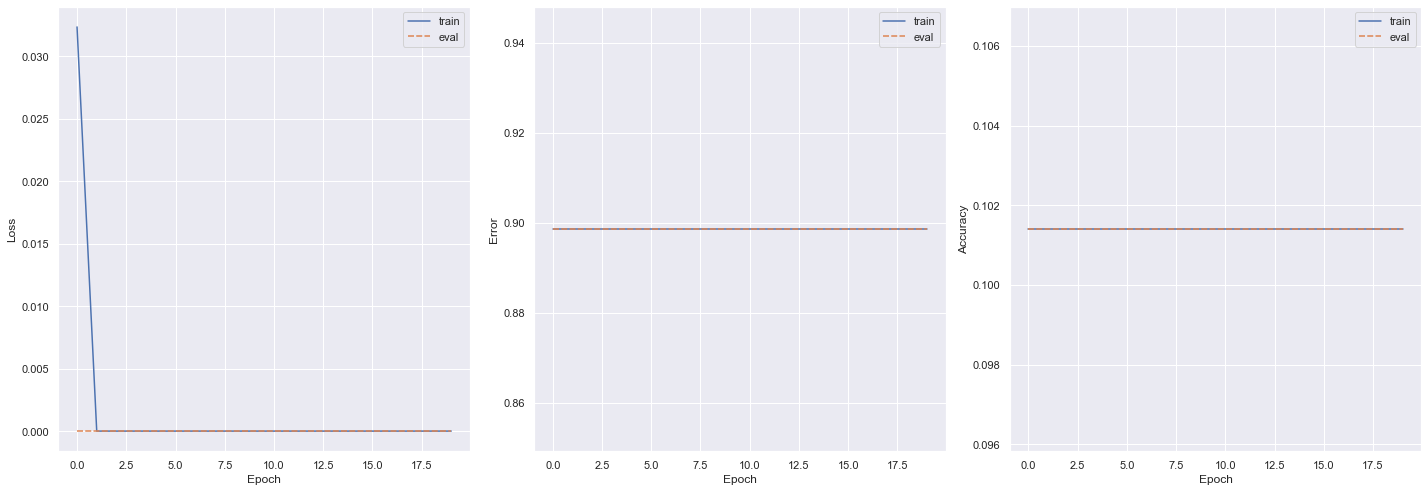

In [27]:
plot_performance(loss=losses, error=errors, accuracy=accuracies)